In [1]:
import numpy as np
import pandas as pd

/usr/local/lib/python3.8/dist-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '2.7.1' or newer of 'numexpr' (version '2.7.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df = pd.read_csv('../data/features_for_clustering_with_scaler.csv')

In [3]:
user_id = df['user_id']
data = df.iloc[:, 1:]

## K-means Clustering

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


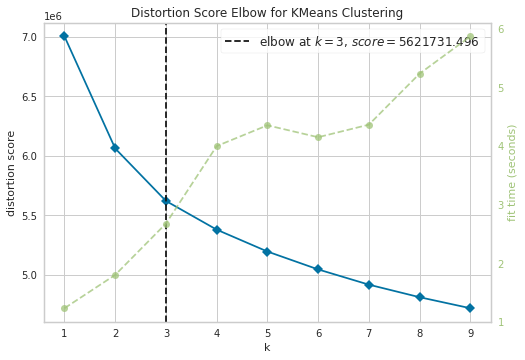

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(1, 10))

In [6]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = kelbow_visualizer(model, data, k=(1,10))
visualizer.fit(data)

elbow에 따라 k=3을 선택

In [7]:
k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 2020)

# 정규화된 데이터에 학습
model.fit(data)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df['cluster'] = model.fit_predict(data)

In [8]:
df['cluster'].value_counts()

2    125254
1     77662
0     59209
Name: cluster, dtype: int64

In [53]:
from yellowbrick.cluster import SilhouetteVisualizer

/home/work/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


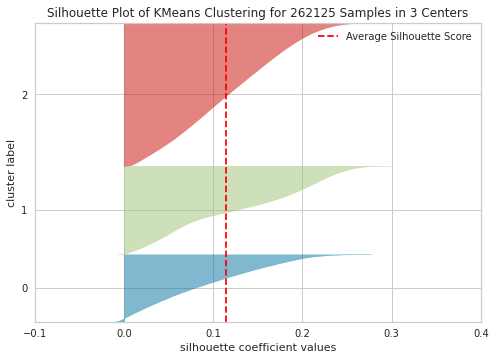

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 262125 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
#visualizer 생성
visualizer_2 = SilhouetteVisualizer(model, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_2.fit(data)      
visualizer_2.show()

In [58]:
from sklearn.metrics import silhouette_samples, silhouette_score

average_score = silhouette_score(data, df['cluster'])

In [59]:
average_score

0.1143258807088333

In [60]:
# 모든 개별 데이터의실루엣 계수값 
score_samples = silhouette_samples(data, df['cluster'])

df['silhouette_coeff'] = score_samples

In [61]:
# 군집별 평균 실루엣 계수 값
df.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.088278
1    0.128017
2    0.118150
Name: silhouette_coeff, dtype: float64

In [ ]:
df.to_csv('kmeans_result.csv', index = False)

## GMM

K-means로 군집화된 군집별로 2개씩 군집화를 진행

In [12]:
df_0 = df.query('cluster==0').iloc[:, 1:]
df_1 = df.query('cluster==1').iloc[:, 1:]
df_2 = df.query('cluster==2').iloc[:, 1:]

In [14]:
from sklearn.mixture import GaussianMixture

gmm_0 = GaussianMixture(n_components=2, random_state=2020).fit(df_0)
gmm_1 = GaussianMixture(n_components=2, random_state=2020).fit(df_1)
gmm_2 = GaussianMixture(n_components=2, random_state=2020).fit(df_2)

In [15]:
gmm_0_labels = gmm_0.predict(df_0)
gmm_1_labels = gmm_1.predict(df_1)
gmm_2_labels = gmm_2.predict(df_2)

In [16]:
df_0['gmm_cluster'] = gmm_0_labels
df_1['gmm_cluster'] = gmm_1_labels
df_2['gmm_cluster'] = gmm_2_labels

In [20]:
df_final = pd.concat([df_0, df_1, df_2], axis=0)

In [25]:
df_final.groupby(['cluster', 'gmm_cluster']).event_count.count()

cluster  gmm_cluster
0        0              39729
         1              19480
1        0              51229
         1              26433
2        0              52731
         1              72523
Name: event_count, dtype: int64

In [33]:
df_final.cluster = df_final.cluster.astype('str')
df_final.gmm_cluster = df_final.gmm_cluster.astype('str')

In [35]:
df_final['label'] = df_final['cluster'] + df_final['gmm_cluster']

In [37]:
df_final['label'].value_counts()

21    72523
20    52731
10    51229
00    39729
11    26433
01    19480
Name: label, dtype: int64

In [44]:
df_final['label'] = df_final['label'].apply(lambda x : 0 if x=='21' else 1 
                                                         if x=='20' else 2
                                                         if x=='10' else 3
                                                         if x=='00' else 4
                                                         if x=='11' else 5)

6개의 그룹으로 군집화한 전체 실루엣계수 평균

In [49]:
from sklearn.metrics import silhouette_samples, silhouette_score

average_score = silhouette_score(df_final.iloc[:,:-3], df_final['label'])

In [50]:
average_score

0.010675641049460819

In [51]:
# 모든 개별 데이터의실루엣 계수값 
score_samples = silhouette_samples(df_final.iloc[:,:-3], df_final['label'])

df_final['silhouette_coeff'] = score_samples

In [52]:
# 군집별 평균 실루엣 계수 값
df_final.groupby('label')['silhouette_coeff'].mean()

label
0   -0.008613
1    0.034099
2   -0.029059
3    0.001758
4    0.088374
5    0.036333
Name: silhouette_coeff, dtype: float64

GMM까지 사용해보았지만, 성능이 좋아지지 않아 기존의 K-means Clustering으로 군집화를 진행하였다.  
실루엣 계수가 낮지만 다른 군집화에 비해 근접한 데이터 분포를 가지며 군집별로 점수의 편차가 크지 않기 때문에 적절한 군집화로 판단하였다.